## Exercises for Physical Models for Living Systems, homework 7
Group members:
* Golan Rodrigo 1142802
* Zoppellari Elena 2076715

In [201]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In a genetic network, we can find two entangled feedback loops: $T$, which represents the loop that controls the transport proteins from extracellular environment $\sigma$ (extracellular concentration) and $E$, which represent the loop that controls transcription of enzymes responsible for the metabolism of $s$ (intracellular concentration). These loops can be either be negative or positive according to their influence on $s$. Given also the evolution of $s$, the network is descibed by the following system of ODEs:

$$
\begin{cases}
\frac{\partial s}{\partial t} = \sigma T -\gamma E s - s \\ 
\frac{\partial T}{\partial t} = A_T(R^{tot},s)-T  \\
\frac{\partial E}{\partial t} = A_E(R^{tot},s)-E
\end{cases}
$$

The coefficients $A_{T, E}$ are:

$$
A_{T, E} = 
\begin{cases}
\epsilon + \frac{A_{max}}{1+(R^*/K_{T,E})^{h_{T,E}}} \qquad \text{if R inhibits T,E} \\
\epsilon + \frac{A_{max}(R^*/K_{T,E})^{h_{T,E}}}{1+(R^*/K_{T,E})^{h_{T,E}}} \qquad \text{if R activates T,E}
\end{cases}
$$

where the regulator $R^*$ depends on the case:

$$
R^* =
\begin{cases}
R_{free} = R_{tot} \frac{1}{1+(s/K)^h_s}  \qquad \text{for i-motifs} \\
R_S = R_{tot} \frac{(s/K)^h_s}{1+(s/K)^h_s}  \qquad \text{for a-motifs}
\end{cases}
$$

In following implementation we have considered the standard parameters (also used in the reference [article](https://www.pnas.org/doi/epdf/10.1073/pnas.0706231105)): $h_s=1$, $K=1$, $h = h_E = h_T = 2$, $K_E = K_T = 1$, $\gamma = 100$ (metabolic rate per enzyme), $R^{tot} = 100$ (total concentration of regulators), $A_{max} = 1$ and $\epsilon = 0.01$ (basal activity).



The four possible negative and positive FL combinations are represented in the following schematic figure:

![vv](scheme.png)

The code below allows to consider all the eight cases illustrated by the use of the parameters $A_T$, $A_E$ and $act$. In particular, $A_T$, $A_E$ are equal to 0 if R inhibits them, 1 otherwise.
| motif | $A_T$ | $A_E$ | $act$ |
| ----- | ----- | ----- | ----- |
| $--i$ | 1  | 0 | i |
| $--a$ | 0 | 1 | e |
| $+-i$ | 0 | 0 | i |
| $+-a$ | 1 | 1 | e |
| $-+i$ | 1 | 1 | i |
| $-+a$ | 0 | 0 | e |
| $++i$ | 0 | 1 | i |
| $++a$ | 1 | 0 | e |

The system of ode is resolved for each motif and for each $\sigma$ values in range $\sigma \in [10^{-1}, 10^{4}]$ using the standard constant values mentioned before. The system is solved also for the cases in which $T=1$ (only metabolism loop active) and $E=1$ (only transport loop active).

In [203]:
# function of the system
# function that returns dz/dt
def model(z,t,sigma,gamma,l,R,KT,KE,h, type, A_T, A_E, act):
    '''
    This function defines the system of ode model. In particular, the parameters:
    - gamma,l,R,KT,KE,h are the constant defined below
    - type can have the values 0, 1, 2. 1 is the case with E=1, 2 is the case with T=1, 0 normal case
    - A_T and E_T represent the coefficient defined in the introduction. If they are equal 0 we are in the case where R inhibits them, 1 otherwise
    - act can have the value "i" or "a": in the first case R^* = R_{free}, in the second R^* = R_S, as described in the introduction
    '''
    # initial conditions
    s = z[0]
    if type == 0:
        T = z[1]
        E = z[2]
    elif type == 1:
        T = z[1]
        E = 1
    elif type == 2:
        E = z[2]
        T = 1

    # system of ode
    dsdt = sigma*T-gamma*E*s-s
    if act== "a":
        Rs = R_s(R, s)
    elif act== "i":
        Rs = R_f(R, s)
    if A_T == 0:
        dTdt = l+1/(1+(Rs/KT)**h)-T
    elif A_T == 1:
        dTdt = l+(Rs/KT)**h/(1+(Rs/KT)**h)-T
    if A_E == 0:
        dEdt = l+1/(1+(Rs/KE)**h)-E
    elif A_E == 1:
        dEdt = l+(Rs/KE)**h/(1+(Rs/KE)**h)-E

    # return solution
    dzdt = [dsdt,dTdt,dEdt]
    return dzdt

def R_s(R, s):
    Rs = R * s / (1 + s)
    return Rs

def R_f(R, s):
    Rf = R / (1 + s)
    return Rf
    
# number of time points
n = 200

# time points
t = np.linspace(0,50,n)

# sigma ranges: we want to collect the stable result for each sigma value in the range
sigma_range=np.linspace(0.1,10000,100000)
sigma_r_inverse=np.linspace(10000,0.1,100000)

# standard constant parameters
gamma = 100
R = 10 # R_tot
KT = 1
KE = KT
h = 2 # h = h_T = h_E
l = 0.01 # basal activity
# Initialize dictionaries to store results
save_s = {}
save_flux = {} # flux: \sigma T = \gamma * E*s +s at stability
save_s_i = {}
save_flux_i = {}

for i in range(3): # because we have 3 cases: T=1, E=1 and normal
    # initialize for every case
    z0 = [0.01,1,0.1]
    save_s[i] = [z0[0]]
    if i == 2: # when T=1 it doesn't make sense to save \sigma * T, but since at stability we have \sigma * T = \gamma * E*s +s, we can obtain the value using this equivalence
        save_flux[i] = [gamma*z0[2]*z0[0]+z0[0]]
    else:
        save_flux[i] = [z0[1] * 0.1] # initialize T * \sigma(0)
        
    for sigma in sigma_range:   
        # solve ODE
        z = odeint(model, z0, t, args=(sigma,gamma,l,R,KT,KE,h,i,0,0,"a"))
        save_s[i].append(z[-1][0])
        if i == 2:
            save_flux[i].append(gamma*z[-1][2]*z[-1][0]+z[-1][0])
        else:
            save_flux[i].append(z[-1][1] * sigma)   
        # next initial condition
        z0 = z[-1]
        
    save_s_i[i] = [z0[0]]
    if i == 2:
        save_flux_i[i] = [gamma*z0[2]*z0[0]+z0[0]]
    else:
        save_flux_i[i] = [z0[1] * 1000]

    # reverse the sigma order
    for sigma in sigma_r_inverse:
        # solve ODE
        z = odeint(model, z0, t, args=(sigma,gamma,l,R,KT,KE,h,i,0,0,"a"))
        save_s_i[i].append(z[-1][0])
        if i == 2:
            save_flux_i[i].append(gamma*z[-1][2]*z[-1][0]+z[-1][0])
        else:
            save_flux_i[i].append(z[-1][1] * sigma)
        # next initial condition
        z0 = z[-1]

In [213]:
'''
# save parameters into dictionaries
fashion_a = {}
fashion_a[0] = save_s
fashion_a[1] = save_flux
fashion_a[2] = save_s_i
fashion_a[3] = save_flux_i'''

'\n# save parameters into dictionaries\nfashion_a = {}\nfashion_a[0] = save_s\nfashion_a[1] = save_flux\nfashion_a[2] = save_s_i\nfashion_a[3] = save_flux_i'

In [208]:
'''
# save all dictionaries into a npz file
np.savez('saved_data.npz', collector_i=collector_i, collector_a=collector_a, fashion_i=fashion_i, fashion_a=fashion_a,
         social_i=social_i, social_a=social_a, consumer_i=consumer_i, consumer_a=consumer_a)
'''

"\n# save all dictionaries into a npz file\nnp.savez('saved_data.npz', collector_i=collector_i, collector_a=collector_a, fashion_i=fashion_i, fashion_a=fashion_a,\n         social_i=social_i, social_a=social_a, consumer_i=consumer_i, consumer_a=consumer_a)\n"

In [214]:
# load all data contained in npz file     
loaded_data = np.load('saved_data.npz', allow_pickle=True) #MUST ALLOW PICKLE FOR ORDERED DATA
collector_i = loaded_data['collector_i'].item()
#loaded_collector_i = loaded_data['collector_i'] NO GOOD WITH NON NP DATA LIKE PYTHON DICT
collector_a = loaded_data['collector_a'].item()
socialist_i = loaded_data['social_i'].item()
socialist_a = loaded_data['social_a'].item()
consumer_i = loaded_data['consumer_i'].item()
consumer_a = loaded_data['consumer_a'].item()
fashion_i = loaded_data['fashion_i'].item()
fashion_a = loaded_data['fashion_a'].item()

The subsequent plots show the behaviour of all eight entangled feedback loop motifs as in the [article](https://www.pnas.org/doi/epdf/10.1073/pnas.0706231105), including inhibited-motifs in addition to the activated-motifs. The results are obtained by following the authors' approach: two sweeps of the value of $\sigma$ are made, the first from 0.1 to 10,000, and the second from 10,000 back to 0.1 (dashed). At each value of $\sigma$, the initial values for $E, T$ are given by the solutions at the previous concentration and the equations are numerically integrated (odeint) until new steady state is found. Thus, two simulations contribute to each plot showing hysterisis where there is some bistability. 
Plots show the steady state values of s and influx ($\sigma T = \gamma E s + s$) as a function of $\sigma$. In all plots, the black curve shows the behaviour for standard parameter values. The red curve shows the behaviour when only the transport loop is active, i.e., $E = 1$. The blue curve is produced by keeping $T = 1$, i.e., only the 
metabolism loop is active.

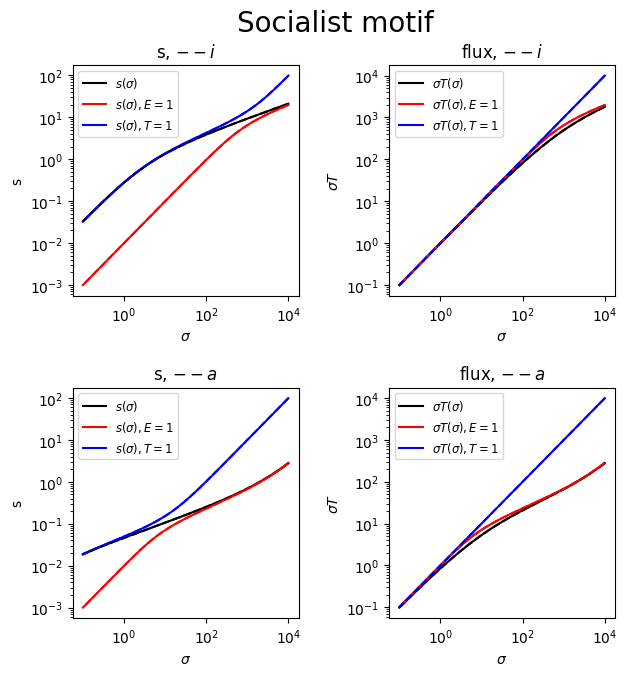

In [215]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(7,7))
plt.suptitle("Socialist motif", fontsize=20)
plt.subplots_adjust(top=0.9, wspace=0.4, hspace=0.4)
for i in range(2):
    ax[0][i].set_xscale('log')
    ax[0][i].set_yscale('log')
    ax[0][i].plot(sigma_range, social_i[i][0][1:], color="black")
    ax[0][i].plot(sigma_range, social_i[i][1][1:], color="red")
    ax[0][i].plot(sigma_range, social_i[i][2][1:], color="blue")
    ax[0][i].plot(sigma_r_inverse, social_i[i+2][0][1:], color="black",linestyle="dashed")
    ax[0][i].plot(sigma_r_inverse, social_i[i+2][1][1:], color="red",linestyle="dashed")
    ax[0][i].plot(sigma_r_inverse, social_i[i+2][2][1:], color="blue",linestyle="dashed")
    ax[0][0].set_title("s, $--i$")
    ax[0][0].set_ylabel("s")
    ax[0][1].set_title("flux, $--i$")
    ax[0][1].set_ylabel("$\sigma T$")
    ax[0][i].set_xlabel("$\sigma$")
    ax[0][0].legend(["$s(\sigma)$", "$s(\sigma), E=1$", "$s(\sigma), T=1$"], fontsize='small')
    ax[0][1].legend(["$\sigma T(\sigma)$", "$\sigma T(\sigma), E=1$", "$\sigma T(\sigma), T=1$"], fontsize='small')
for i in range(2):
    ax[1][i].set_xscale('log')
    ax[1][i].set_yscale('log')
    ax[1][i].plot(sigma_range, social_a[i][0][1:], color="black")
    ax[1][i].plot(sigma_range, social_a[i][1][1:], color="red")
    ax[1][i].plot(sigma_range, social_a[i][2][1:], color="blue")
    ax[1][i].plot(sigma_r_inverse, social_a[i+2][0][1:], color="black",linestyle="dashed")
    ax[1][i].plot(sigma_r_inverse, social_a[i+2][1][1:], color="red",linestyle="dashed")
    ax[1][i].plot(sigma_r_inverse, social_a[i+2][2][1:], color="blue",linestyle="dashed")
    ax[1][0].set_title("s, $--a$")
    ax[1][0].set_ylabel("s")
    ax[1][1].set_title("flux, $--a$")
    ax[1][1].set_ylabel("$\sigma T$")
    ax[1][i].set_xlabel("$\sigma$")
    ax[1][0].legend(["$s(\sigma)$", "$s(\sigma), E=1$", "$s(\sigma), T=1$"], fontsize='small')
    ax[1][1].legend(["$\sigma T(\sigma)$", "$\sigma T(\sigma), E=1$", "$\sigma T(\sigma), T=1$"], fontsize='small')

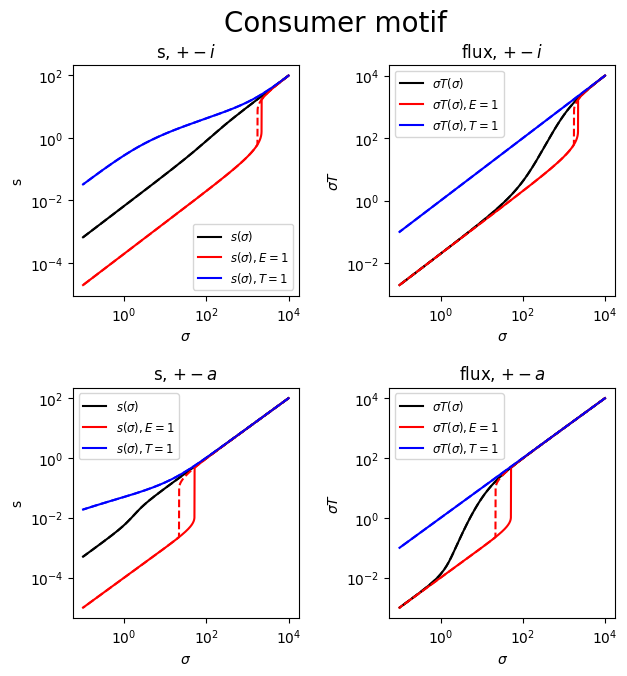

In [216]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(7,7))
plt.suptitle("Consumer motif", fontsize=20)
plt.subplots_adjust(top=0.9, wspace=0.4, hspace=0.4)
for i in range(2):
    ax[0][i].set_xscale('log')
    ax[0][i].set_yscale('log')
    ax[0][i].plot(sigma_range, consumer_i[i][0][1:], color="black")
    ax[0][i].plot(sigma_range, consumer_i[i][1][1:], color="red")
    ax[0][i].plot(sigma_range, consumer_i[i][2][1:], color="blue")
    ax[0][i].plot(sigma_r_inverse, consumer_i[i+2][0][1:], color="black",linestyle="dashed")
    ax[0][i].plot(sigma_r_inverse, consumer_i[i+2][1][1:], color="red",linestyle="dashed")
    ax[0][i].plot(sigma_r_inverse, consumer_i[i+2][2][1:], color="blue",linestyle="dashed")
    ax[0][0].set_title("s, $+-i$")
    ax[0][0].set_ylabel("s")
    ax[0][1].set_title("flux, $+-i$")
    ax[0][1].set_ylabel("$\sigma T$")
    ax[0][i].set_xlabel("$\sigma$")
    ax[0][0].legend(["$s(\sigma)$", "$s(\sigma), E=1$", "$s(\sigma), T=1$"], fontsize='small')
    ax[0][1].legend(["$\sigma T(\sigma)$", "$\sigma T(\sigma), E=1$", "$\sigma T(\sigma), T=1$"], fontsize='small')
for i in range(2):
    ax[1][i].set_xscale('log')
    ax[1][i].set_yscale('log')
    ax[1][i].plot(sigma_range, consumer_a[i][0][1:], color="black")
    ax[1][i].plot(sigma_range, consumer_a[i][1][1:], color="red")
    ax[1][i].plot(sigma_range, consumer_a[i][2][1:], color="blue")
    ax[1][i].plot(sigma_r_inverse, consumer_a[i+2][0][1:], color="black",linestyle="dashed")
    ax[1][i].plot(sigma_r_inverse, consumer_a[i+2][1][1:], color="red",linestyle="dashed")
    ax[1][i].plot(sigma_r_inverse, consumer_a[i+2][2][1:], color="blue",linestyle="dashed")
    ax[1][0].set_title("s, $+-a$")
    ax[1][0].set_ylabel("s")
    ax[1][1].set_title("flux, $+-a$")
    ax[1][1].set_ylabel("$\sigma T$")
    ax[1][i].set_xlabel("$\sigma$")
    ax[1][0].legend(["$s(\sigma)$", "$s(\sigma), E=1$", "$s(\sigma), T=1$"], fontsize='small')
    ax[1][1].legend(["$\sigma T(\sigma)$", "$\sigma T(\sigma), E=1$", "$\sigma T(\sigma), T=1$"], fontsize='small')

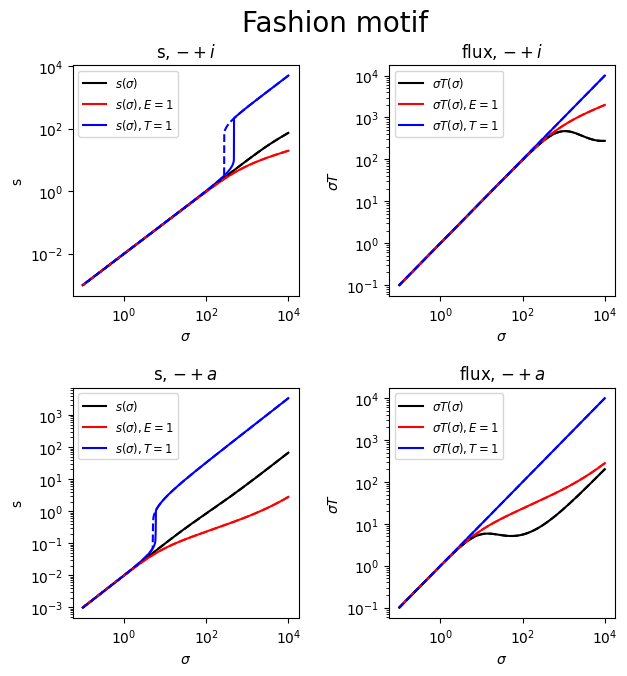

In [217]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(7,7))
plt.suptitle("Fashion motif", fontsize=20)
plt.subplots_adjust(top=0.9, wspace=0.4, hspace=0.4)
for i in range(2):
    ax[0][i].set_xscale('log')
    ax[0][i].set_yscale('log')
    ax[0][i].plot(sigma_range, fashion_i[i][0][1:], color="black")
    ax[0][i].plot(sigma_range, fashion_i[i][1][1:], color="red")
    ax[0][i].plot(sigma_range, fashion_i[i][2][1:], color="blue")
    ax[0][i].plot(sigma_r_inverse, fashion_i[i+2][0][1:], color="black",linestyle="dashed")
    ax[0][i].plot(sigma_r_inverse, fashion_i[i+2][1][1:], color="red",linestyle="dashed")
    ax[0][i].plot(sigma_r_inverse, fashion_i[i+2][2][1:], color="blue",linestyle="dashed")
    ax[0][0].set_title("s, $-+i$")
    ax[0][0].set_ylabel("s")
    ax[0][1].set_title("flux, $-+i$")
    ax[0][1].set_ylabel("$\sigma T$")
    ax[0][i].set_xlabel("$\sigma$")
    ax[0][0].legend(["$s(\sigma)$", "$s(\sigma), E=1$", "$s(\sigma), T=1$"], fontsize='small')
    ax[0][1].legend(["$\sigma T(\sigma)$", "$\sigma T(\sigma), E=1$", "$\sigma T(\sigma), T=1$"], fontsize='small')
for i in range(2):
    ax[1][i].set_xscale('log')
    ax[1][i].set_yscale('log')
    ax[1][i].plot(sigma_range, fashion_a[i][0][1:], color="black")
    ax[1][i].plot(sigma_range, fashion_a[i][1][1:], color="red")
    ax[1][i].plot(sigma_range, fashion_a[i][2][1:], color="blue")
    ax[1][i].plot(sigma_r_inverse, fashion_a[i+2][0][1:], color="black",linestyle="dashed")
    ax[1][i].plot(sigma_r_inverse, fashion_a[i+2][1][1:], color="red",linestyle="dashed")
    ax[1][i].plot(sigma_r_inverse, fashion_a[i+2][2][1:], color="blue",linestyle="dashed")
    ax[1][0].set_title("s, $-+a$")
    ax[1][0].set_ylabel("s")
    ax[1][1].set_title("flux, $-+a$")
    ax[1][1].set_ylabel("$\sigma T$")
    ax[1][i].set_xlabel("$\sigma$")
    ax[1][0].legend(["$s(\sigma)$", "$s(\sigma), E=1$", "$s(\sigma), T=1$"], fontsize='small')
    ax[1][1].legend(["$\sigma T(\sigma)$", "$\sigma T(\sigma), E=1$", "$\sigma T(\sigma), T=1$"], fontsize='small')

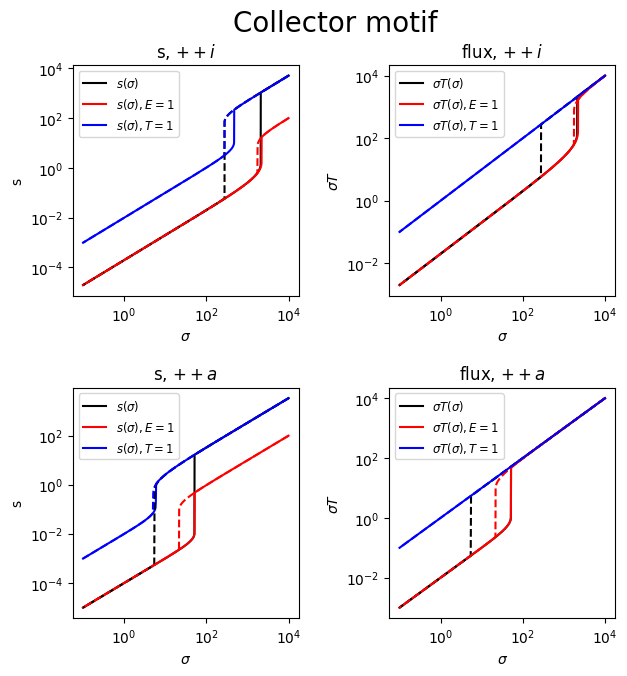

In [218]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(7,7))
plt.suptitle("Collector motif", fontsize=20)
plt.subplots_adjust(top=0.9, wspace=0.4, hspace=0.4)
for i in range(2):
    ax[0][i].set_xscale('log')
    ax[0][i].set_yscale('log')
    ax[0][i].plot(sigma_range, collector_i[i][0][1:], color="black")
    ax[0][i].plot(sigma_range, collector_i[i][1][1:], color="red")
    ax[0][i].plot(sigma_range, collector_i[i][2][1:], color="blue")
    ax[0][i].plot(sigma_r_inverse, collector_i[i+2][0][1:], color="black",linestyle="dashed")
    ax[0][i].plot(sigma_r_inverse, collector_i[i+2][1][1:], color="red",linestyle="dashed")
    ax[0][i].plot(sigma_r_inverse, collector_i[i+2][2][1:], color="blue",linestyle="dashed")
    ax[0][0].set_title("s, $++i$")
    ax[0][0].set_ylabel("s")
    ax[0][1].set_title("flux, $++i$")
    ax[0][1].set_ylabel("$\sigma T$")
    ax[0][i].set_xlabel("$\sigma$")
    ax[0][0].legend(["$s(\sigma)$", "$s(\sigma), E=1$", "$s(\sigma), T=1$"], fontsize='small')
    ax[0][1].legend(["$\sigma T(\sigma)$", "$\sigma T(\sigma), E=1$", "$\sigma T(\sigma), T=1$"], fontsize='small')
for i in range(2):
    ax[1][i].set_xscale('log')
    ax[1][i].set_yscale('log')
    ax[1][i].plot(sigma_range, collector_a[i][0][1:], color="black")
    ax[1][i].plot(sigma_range, collector_a[i][1][1:], color="red")
    ax[1][i].plot(sigma_range, collector_a[i][2][1:], color="blue")
    ax[1][i].plot(sigma_r_inverse, collector_a[i+2][0][1:], color="black",linestyle="dashed")
    ax[1][i].plot(sigma_r_inverse, collector_a[i+2][1][1:], color="red",linestyle="dashed")
    ax[1][i].plot(sigma_r_inverse, collector_a[i+2][2][1:], color="blue",linestyle="dashed")
    ax[1][0].set_title("s, $++a$")
    ax[1][0].set_ylabel("s")
    ax[1][1].set_title("flux, $++a$")
    ax[1][1].set_ylabel("$\sigma T$")
    ax[1][i].set_xlabel("$\sigma$")
    ax[1][0].legend(["$s(\sigma)$", "$s(\sigma), E=1$", "$s(\sigma), T=1$"], fontsize='small')
    ax[1][1].legend(["$\sigma T(\sigma)$", "$\sigma T(\sigma), E=1$", "$\sigma T(\sigma), T=1$"], fontsize='small')